<a href="https://colab.research.google.com/github/kmazurov/ML-model-for-a-metalworking-enterprise/blob/main/%D0%A2%D0%B5%D1%81%D1%82%D0%BE%D0%B2%D0%BE%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_%D0%A3%D1%87%D0%B8_%D1%80%D1%83.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A/B–тестирование

В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. Необходимо проанализировать итоги эксперемента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

Описание данных:

1) Таблица groups - информация о пренадлежности пользователя к контрольно или эксперементальной группе:
- user_id — уникальный идентификатор пользователя
- grp — А - контрольная группа, В - целевая группа

2) Таблица active_studs - информация о пользователях, которые загли на платформу в дни проведения эксперемента:
- student_id — уникальный идентификатор пользователя

3) Таблица checks - информация об оплатах пользователей в дни проведения эксперемента:
- student_id — уникальный идентификатор пользователя
- rev — сумма соверешонной транзакции

# План работы

Стандартная операция по проведению А/B теста выполняется в несколько этапов:

1. Определение цели
2. Определение метрик
3. Формулировка гипотез
4. Настройка эксперимента
5. Проведение эксперимента
6. Анализ результатов

В данной работе будет проведен последний этап работы над А/B тестом - анализ результатов. 

Весь анализ разобьем на несколько основных шагов: 
**1. Сформулируем основную гипотезу:**
*Средний чек пользователей из группы А отличается от среднего чека пользователей из группы В*
- Н0 Нулевая гипотеза - Средний чек пользователей из группы А больше, чем пользователей из группы В
- Н1 Альтернативная гипотеза - Средний чек пользователей из группы А меньше, чем пользователей из группы В
- Уровень значимости 5%

**2. Полученную выгрузку данных объединим в один датафрейм для удобства работы.** Проведем предобработку и исследовательский анализ данных.

**3. Сделаем выборку, проверим ее распределение на нормальность.**

**4. Проверим гипотезы с помощью t-критерия Стьюдента**

В работе над задачей я использую Google Colab, поэтому первый шаг - это подключить Google Drive и загрузить данные. Однако, Google Colab передает данные пользователей на серверы Google, поэтому он не подходит для работы с конфидициальными данными. В конкретном этом задании данные обезличены.

# Шаг 1. Общий обзор  и предобработка данных

In [1]:
# Импорт необходимых модулей для работы

import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!ls 'drive/My Drive/Colab Notebooks/Datasets'

active_studs.csv  games.csv	  internet.csv		  users_behavior.csv
calls.csv	  geo_data_0.csv  messages.csv		  users.csv
checks.csv	  geo_data_1.csv  preprocessing_data.csv
checks.gsheet	  geo_data_2.csv  real_estate_data.csv
Churn.csv	  groups.csv	  tariffs.csv


In [3]:
group_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/groups.csv', sep=';')

In [4]:
active_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/active_studs.csv', sep=';')

In [5]:
checks_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/checks.csv', sep=';')

Перед началом исследования необходимо проверить данные на их полноту, т.е. имеются ли пропущенные значения, какие типы данных представлены, общие описание (медиана, среднее, стандартное отклонение и пр).

In [6]:
# Первичный обзор данных для таблицы groups.csv

display(group_data.head())
display(group_data.describe())
display(group_data.info())
display(group_data.isnull().sum())

,id,grp
0,1206794,B
1,331024,B
2,1733498,A
3,161574,B
4,168443,B


,id
count,7.457600e+04
mean,2.165617e+06
std,2.786959e+06
min,1.489000e+03
25%,9.197188e+05
50%,1.669752e+06
75%,3.328121e+06
max,2.010677e+08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74576 entries, 0 to 74575
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74576 non-null  int64 
 1   grp     74576 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


None

id     0
grp    0
dtype: int64

In [7]:
# Первичный обзор данных для таблицы active_studs.csv

display(active_data.head())
display(active_data.describe())
display(active_data.info())
display(active_data.isnull().sum())

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


,student_id
count,8.341000e+03
mean,2.448547e+06
std,1.564978e+06
min,1.627000e+03
25%,1.118405e+06
50%,2.094192e+06
75%,3.638877e+06
max,5.951797e+06


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


None

student_id    0
dtype: int64

In [8]:
# Первичный обзор данных для таблицы checks.csv

display(checks_data.head())
display(checks_data.describe())
display(checks_data.info())
display(checks_data.isnull().sum())

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


,student_id,rev
count,5.410000e+02,541.000000
mean,2.514772e+06,1059.752317
std,1.726839e+06,762.712359
min,1.627000e+03,199.000000
25%,9.871290e+05,290.000000
50%,2.526021e+06,840.000000
75%,3.993249e+06,1900.000000
max,5.740903e+06,4650.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


None

student_id    0
rev           0
dtype: int64

### Промежуточный вывод

1. Для удобства работы скорректируем название столбца в таблице groups.csv к student_id

2. Серьезных отколонений в данных нет

3. Пропущенные значения в таблицах отсутсвуют

4. Необходимости в изменении типов данных нет

In [9]:
# Скорректируем название столбца в таблице groups.csv

group_data = group_data.rename({'id': 'student_id', 'rev': 'rev'}, axis=1)

In [10]:
# Объединим таблицы для удобства анализа

data = pd.merge(group_data.append(active_data), checks_data, on=('student_id'), how ='left')

В целом, можно было использовать параметр *right* для удаления данных, которым не было найдено соответсвие в таблицах. Но я не хочу потрерять важные данные, поэтому использую параметр *left*.

In [11]:
display(data.head())
display(data.describe())
display(data.info())
display(data.isnull().sum())

,student_id,grp,rev
0,1206794,B,NaN
1,331024,B,NaN
2,1733498,A,NaN
3,161574,B,NaN
4,168443,B,NaN


,student_id,rev
count,8.291700e+04,933.000000
mean,2.194078e+06,1115.884252
std,2.690611e+06,792.735345
min,1.489000e+03,199.000000
25%,9.797000e+05,290.000000
50%,1.701114e+06,870.000000
75%,3.359535e+06,1900.000000
max,2.010677e+08,4650.000000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 82917 entries, 0 to 82916
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  82917 non-null  int64  
 1   grp         74576 non-null  object 
 2   rev         933 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.5+ MB


None

student_id        0
grp            8341
rev           81984
dtype: int64

In [12]:
# Отсутствующие данные удалим, т.к. эти пользователи не были внесены в A/B тест

data = data.dropna().reset_index(drop = True)

In [13]:
display(data.head())
display(data.describe())
display(data.info())
display(data.isnull().sum())

,student_id,grp,rev
0,456232,B,690.0
1,393127,B,290.0
2,459662,B,690.0
3,4163705,B,580.0
4,387124,B,690.0


,student_id,rev
count,5.410000e+02,541.000000
mean,2.514772e+06,1059.752317
std,1.726839e+06,762.712359
min,1.627000e+03,199.000000
25%,9.871290e+05,290.000000
50%,2.526021e+06,840.000000
75%,3.993249e+06,1900.000000
max,5.740903e+06,4650.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   grp         541 non-null    object 
 2   rev         541 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 12.8+ KB


None

student_id    0
grp           0
rev           0
dtype: int64

In [14]:
# Проверим размерность, что никакие данные из таблицы checks.csv не потерялись
len(data) - len(checks_data)

0

# Шаг 2. Исследовательский анализ данных

In [15]:
# Проверим распределение по группам

data['grp'].value_counts()

B    434
A    107
Name: grp, dtype: int64

In [16]:
# Сравним базовые метрики по выборке

print('Средний чек по датафрейму: {:.2f}'.format(data.rev.median()))

avg_check = data.pivot_table(index = 'grp', values = 'rev', aggfunc = ['median', 'mean', 'sum']).reset_index()
avg_check.columns = ['Группа', 'Медиана', 'Арифметическое среднее', 'Сумма чеков']
display(avg_check)

Средний чек по датафрейму: 840.00


,Группа,Медиана,Арифметическое среднее,Сумма чеков
0,A,690.0,860.710280,92096.0000
1,B,935.0,1108.824893,481230.0036


### Промежуточный вывод

Медана, среднее арифметическое и сумма чеков по группе В выше, чем у группы А. Однако, нужно учитывать, что выборки не сбалансированы, поэтому использовать эти данные для финального принятия решения об успешности проведенного А/B теста нельзя.

In [17]:
# Выделим пользователей, вошедших в группу А и В

a_group = data.query('grp == "A"')
b_group = data.query('grp == "B"')

In [18]:
# Выделим случайным образом 100 пользователей из каждой выборки

a_group_sample = a_group.sample(n=100, random_state=42)
b_group_sample = b_group.sample(n=100, random_state=42)

# Проверка
print(len(a_group_sample))
print(len(b_group_sample))
print('---')
print(a_group_sample.shape)
print(b_group_sample.shape)

100
100
---
(100, 3)
(100, 3)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


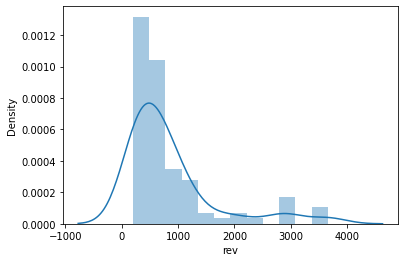

In [19]:
# Проверим распределения на нормальность

a_distplot = sns.distplot(a_group_sample['rev'])
fig = a_distplot.get_figure()

{'boxes': [<matplotlib.lines.Line2D at 0x7f9b477d5050>],
 'caps': [<matplotlib.lines.Line2D at 0x7f9b477dd110>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f9b477e4150>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f9b477ddbd0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f9b477d5650>,
  <matplotlib.lines.Line2D at 0x7f9b477d5b90>]}

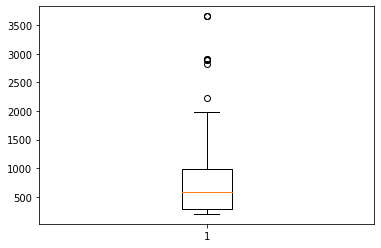

In [20]:
plt.boxplot(a_group_sample['rev'])

# В данных есть выбросы в бОльшую сторону

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


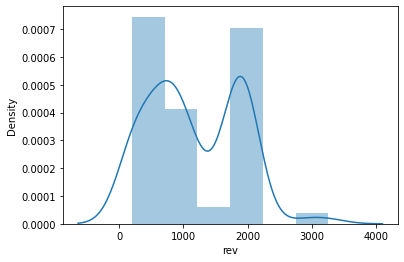

In [21]:
b_distplot = sns.distplot(b_group_sample['rev'])
fig = b_distplot.get_figure()

{'boxes': [<matplotlib.lines.Line2D at 0x7f9b476ce450>],
 'caps': [<matplotlib.lines.Line2D at 0x7f9b476d3490>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f9b476da4d0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f9b476d3f50>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f9b476ce9d0>,
  <matplotlib.lines.Line2D at 0x7f9b476cef10>]}

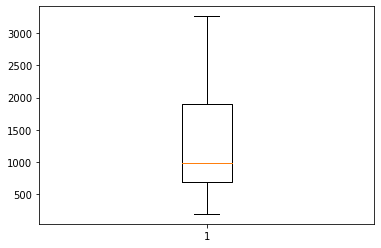

In [22]:
plt.boxplot(b_group_sample['rev'])

# Для группы B данные в целом распределены нормально

# Шаг 3. Проверка гипотез

Напомним основную гипотезу:

*Средний чек пользователей из группы А отличается от среднего чека пользователей из группы В*
- Н0 Нулевая гипотеза - Средний чек пользователей из группы А больше, чем пользователей из группы В
- Н1 Альтернативная гипотеза - Средний чек пользователей из группы А меньше, чем пользователей из группы В

In [23]:
print('cредний чек в группе А:',pd.Series(a_group_sample['rev'].median()))
print('cредний чек в группе B:',pd.Series(b_group_sample['rev'].median()))

alpha = 0.05

results = st.ttest_ind(a_group_sample['rev'], b_group_sample['rev'], equal_var = False)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

print('p-значение: ', results.pvalue)

cредний чек в группе А: 0    590.0
dtype: float64
cредний чек в группе B: 0    990.0
dtype: float64
Отвергаем нулевую гипотезу
p-значение:  0.002946218718785415


## Вывод

1. В ходе исследования была подтверждена гипотеза о том, что средний чек пользователей из группы А меньше, чем пользователей из группы В. Следовательно, результат тестирования новой механики можно охарактеризовать как успешный.

2. В ходе анализа наибольшее внимание обращалось на медиану среднего чека, т.к. медиана менее восприимчива к выбросам, нежели среднее арифметическое.

3. Факторы, которые могли повлиять на увеличение среднего чека в новой механике оплаты: 
- Внедрение возможности оплаты Apple Pay, Google Pay. Пользователи быстрее решаются на покупку, нежели ручной ввод банковских данных. 
- Обновленная страница транзакции, т.е. переход к новому банку-эквайре. Возможно, пользователи доверяют этому банку больше.